In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 10 
plt.rcParams['lines.linewidth'] = 3
%matplotlib inline

# An example of an institutional multi-asset momentum strategy
Here we try to **replicate the multi-asset momentum strategy** based on the academic evidence of [Moskowitz et al. (2012)](https://libkey.io/libraries/239/articles/19074553/full-text-file?utm_source=api_1694) and implemented by AQR according to what was published by Hurst et al. ([2013](https://www.aqr.com/Insights/Research/Journal-Article/Demystifying-Managed-Futures) and [2017](https://www.aqr.com/Insights/Research/Journal-Article/A-Century-of-Evidence-on-Trend-Following-Investing)).

This strategy is implemented by a number of institutional investors, for example [Pimco Trends](https://www.pimco.com.au/en-au/investments/australia/trends-managed-futures-strategy-fund/wholesale). The [AQR Managed Futures](https://funds.aqr.com/funds/aqr-managed-futures-strategy-fund) fund also implements this trategy although it seems they use a more advanced version, compared to the published one, that considers both momentum and mean-reversion indicators.

In this Notebook we will:
1. **Load** the Data
1. Look for Statistical evidence of positive **serial correlation** between past and future returns
1. Build a long/short investment **signal** for each asset
1. Estimate the optimal **size** of the investment position in each asset
1. Combine signal and optimal size to build the **investment position** in each asset
1. Calculate the **performance** of the investment strategy

___
## 1. The Data
Let's start by loading our data on historical prices from 1980 to 2022 of a number of asset classes (Bonds Indices, Equity Indices, Currencies and Commodities. The file has three columns:
1. Name of the Asset
1. Date
1. Prices

Since every obseration is the monthly price of a given asset we can use the first two columns (`Name` and `Date`) as the index of our file. When the index has more than one variable is called a [MultiIndex](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html). 

In [2]:
data = pd.read_csv('Futures_Prices.csv', parse_dates=['Date']).set_index(['Name', 'Date'])
data.head()

Price
Name Date             
AEX  1983-01-31  48.37
     1983-02-28  51.26
     1983-03-31  60.24
     1983-04-29  57.20
     1983-05-31  57.24

Even if we have **single column** of data, the import function creates a DataFrame. For sake of simplicity, let's extract the prices **into a series**. We can do this by using the method **[`DataFrame.squeeze()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.squeeze.html)**. This will reduce any object to **the simplest form without data loss**. A DataFrame with only one column becomes a Series. A Series with a single row would become a simple number (scalar).

In [3]:
prices = data.squeeze()
prices.head()

Name  Date      
AEX   1983-01-31    48.37
      1983-02-28    51.26
      1983-03-31    60.24
      1983-04-29    57.20
      1983-05-31    57.24
Name: Price, dtype: float64

___
#### A bit of coding "stuff"
We could achieve the same result by **selecting a column by name**. This second methodology could also be used to create Series out of a specific variable of a multi-column DataFrame.

In [4]:
prices = data['Price']
prices.head()

Name  Date      
AEX   1983-01-31    48.37
      1983-02-28    51.26
      1983-03-31    60.24
      1983-04-29    57.20
      1983-05-31    57.24
Name: Price, dtype: float64

___
We can also load an ancillary file with the **name and type** of each asset. This will allow us to see what each name refers to. By reading the names you will notice that we do not have all the assets used in the AQR model, but we have a reasonable approximation.

One important [caveat](https://www.oxfordlearnersdictionaries.com/definition/american_english/caveat), before we proceed any further, is the fact that due to **data limitation** we are using **both future prices and index prices**. Index prices do not fully reflect what you can actually trade in the market (the future), hence the results on the performance of this strategy should be considered with caution.

In [5]:
types = pd.read_csv('Futures_Types.csv').set_index('Name')
types

,Type
Name,
AUS10,Bonds
AUS3,Bonds
CAN10,Bonds
FR10,Bonds
GER10,Bonds
...,...
IBEX 35,Equity
Russell 2000,Equity
S&P 500,Equity


___
## 2. Statistical Evidence of Momenutm

First of all we want to test whether we can observe any **positive correlation** between past and future returns. Ideally we want to measure the correlation using different look-back and holding periods, similar to what we find in the table below.

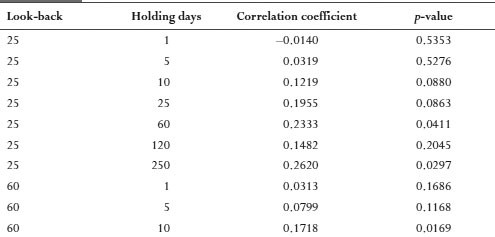

We can start by considering a lookback period of 3 months and a holding period of 1 month. 

To calculate the **log returns** based on the prices we have to remember that

$$ r_{t-k,t} = \log \left(\frac{P_{t}}{P_{t-k}}\right)$$

The calculation below makes use of the method [**`.shift()`**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) to extract the prices in the "previous" periods.  The final **[`s.rename()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.rename.htmlhttps://pandas.pydata.org/docs/reference/api/pandas.Series.rename.html)** is to apply a proper name to the Series (see the indication at the bottom of the printed result).

In [6]:
past_returns = np.log(prices / prices.groupby('Name').shift(3)).rename('Past')
past_returns.head()

Name  Date      
AEX   1983-01-31         NaN
      1983-02-28         NaN
      1983-03-31         NaN
      1983-04-29    0.167674
      1983-05-31    0.110342
Name: Past, dtype: float64

Notice that we have to use the **[`DataFrame.groupby()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)** operator because we want to shift by three months **within each asset**.

In the same way we can find the future return as

$$ r_{t,t+k} = \log \left(\frac{P_{t+k}}{P_{t}}\right)$$

In [7]:
future_returns = np.log(prices.groupby('Name').shift(-1) / prices).rename('Future')
future_returns.head()

Name  Date      
AEX   1983-01-31    0.058031
      1983-02-28    0.161426
      1983-03-31   -0.051783
      1983-04-29    0.000699
      1983-05-31    0.111786
Name: Future, dtype: float64

We can now combine the two series in a single DataFrame. Here we can use **[`DataFrame.join()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html)** because we are merging on the index (`Name` and `date`) rather than on common columns. Please notice that since `.join()` is a DataFrame method we need to transform the series `past_returns` into a DataFrame with **[`Series.to_frame()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.to_frame.htmlhttps://pandas.pydata.org/docs/reference/api/pandas.Series.to_frame.html)**.

The final **[`DataFrame.dropna()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html)** is to be sure that we do not have any missing value in our final DataFrame.

In [8]:
test = past_returns.to_frame().join(future_returns).dropna()
test.head()

Past    Future
Name Date                          
AEX  1983-04-29  0.167674  0.000699
     1983-05-31  0.110342  0.111786
     1983-06-30  0.060703  0.031524
     1983-07-29  0.144010 -0.034967
     1983-08-31  0.108343  0.048499

We can finally **estimate the correlation** coefficient. Pandas has a method **[`DataFrame.corr()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html)** that calculates the correlation matrix between all the columns of a DataFrame:

In [9]:
test.corr()

,Past,Future
Past,1.000000,-0.010132
Future,-0.010132,1.000000


This **does not provide the [p-value](https://en.wikipedia.org/wiki/P-value)** for the estimation. So we do not know if the estimated correlation coefficient is **statistically different** from zero.

We could code our own p-value calculation but since we are lazy we decide to use a **built-in function** for this. We can find functions to perform statistical tests in different places in Python, but the default options is usually [Scipy](https://docs.scipy.org/doc/scipy/reference/), the last piece of our data science stack. Specifically we will use the **stats** sub-module and the different correlation functions. Since we are applying this calculation to a multi-asset setting where different assets have different levels of volatility, it probably safer use a [rank correlation](https://en.wikipedia.org/wiki/Rank_correlation) measure,  that is less affected by outliers, such as **[`scipy.stats.rspearman()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html)**, rather than the traditional linear correlation with  **[`scipy.stats.pearsonr()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)** function.

The basic difference, is that with a rank correlation we ask whether "higher returns" in the past are correlated with "higher returns" in the future, but we **do not impose any linearity assumption**, i.e. we are not asking whether an increase in the past return of 30% leads to an increase in the future return by 30%... This is OK because we are not using the strength of the past return to determine the size of our invstment.

In [10]:
from scipy import stats

stats.spearmanr(test['Past'], test['Future'])

SignificanceResult(statistic=0.0176974212744244, pvalue=0.003955694367702678)

And we see that the correlation is positive, albeit weak, and that the p-value is way below any reasonable treshold, indicating that the estimated correlation, besides being positive, is **statistically different** from zero.

### 2.1 Building the Table
We have now tested a specific combination of look-back period (3 months) and holding period (1 month). Our goal is to build a table where we test multiple combinations. 

Of course, since we are no longer rookies, we **will not copy and paste the code** multiple times... but we will build a simple (double) for-loop.

In [11]:
correla = []

for lookback in [1, 3, 6, 12]:
    for holding in [1, 3, 6 ,12]:
        
        past_ret = np.log(prices / prices.groupby('Name').shift(lookback)).rename('Past')
        future_ret = np.log(prices.groupby('Name').shift(-holding) / prices).rename('Future')
        c_test = past_ret.to_frame().join(future_ret).dropna()

        corr, pvalue = stats.spearmanr(c_test['Past'], c_test['Future'])
        
        correla.append([lookback, holding, corr.round(4), pvalue.round(4)])
        
correlation = pd.DataFrame(correla,columns=['Lookback', 'Holding', 'Correlation', 'P-Value'])         
correlation        

,Lookback,Holding,Correlation,P-Value
0,1,1,0.0020,0.7427
1,1,3,0.0136,0.0274
2,1,6,0.0083,0.1777
3,1,12,0.0239,0.0001
4,3,1,0.0177,0.0040
5,3,3,0.0104,0.0919
6,3,6,-0.0088,0.1556
7,3,12,0.0191,0.0021
8,6,1,0.0116,0.0588
9,6,3,-0.0000,0.9936


___
## 3. The Signal

Now that we have some statistical evidence of momentum let's test our **trading strategy**. The first step is to build a **long/short signal**. In this specific implementation I will use the combination of lookback and holding signal that has the higher correlation:
- Lookback period of 12 months
- Holding period of 1 month

According to the AQR model we go **long** if the lookback return is **positive** and **short** if the lookback return is **negative**. This is quite trivial because in NumPy we have a function **[`np.sign()`](https://numpy.org/doc/stable/reference/generated/numpy.sign.html)** that transform any number into a sign indicator. Specifically given a number $n$, the signal function will return:
- `+1` if $n>0$
- `0` if $n=0$
- `-1` if $n<0$

In [12]:
lookback_return =  np.log(prices / prices.groupby('Name').shift(12)).dropna()
lookback_return.head()

Name  Date      
AEX   1984-01-31    0.573955
      1984-02-29    0.409100
      1984-03-30    0.249616
      1984-04-30    0.270401
      1984-05-31    0.193498
Name: Price, dtype: float64

In [13]:
signal = np.sign(lookback_return)
signal.head()

Name  Date      
AEX   1984-01-31    1.0
      1984-02-29    1.0
      1984-03-30    1.0
      1984-04-30    1.0
      1984-05-31    1.0
Name: Price, dtype: float64

As we can see, since in Jan 1984 the lookback return for the Dutch stock market index is positive, **we will take a long position**. We also notice that we loose the first 12 months of observations (the year 1983) because we need 12 months of past data to build the lookback return, so we can only invest in this asset form 1984. 

We can also briefly look at **how many long and short** position we take every month by using **[`Series.value_counts()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html)** that counts the values of a categorial variable.

In [14]:
positions = signal.groupby('Date').value_counts()
positions.head(10)

Date        Price
1980-12-31   1.0     16
            -1.0     10
1981-01-30  -1.0     13
             1.0     13
1981-02-27   1.0     15
            -1.0     11
1981-03-31   1.0     17
            -1.0      9
1981-04-30   1.0     17
            -1.0      9
Name: Price, dtype: int64

We see that in December 1980 we go long in 16 assets and short in 10...
___
#### ATTENTION: USELESS COMPLICATION

We may not like that the previous function returns an object where for every date the number of positive and negatives **are on two separate rows**. Since we have applied `s.value_counts()` with the **groupby operator** we receive as a result a series with a **MultiIndex** where the first level is the date and the second level are the values of the categorical variable (`+1` and `-1`). 

We can "fix" this by taking the second level of the MultiIndex and **putting the data in different columns**. This is called **unstacking** the index and can be easily achieved with the function **[`Series.unstack()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.unstack.html)** passing as an argument the level of the index that we want to move to columns (remember that in Python we start counting from `0` so the second level is `1`).

In [15]:
positions = positions.unstack(1)
positions.head(10)

Price,-1.0,0.0,1.0
Date,,,
1980-12-31,10.0,NaN,16.0
1981-01-30,13.0,NaN,13.0
1981-02-27,11.0,NaN,15.0
1981-03-31,9.0,NaN,17.0
1981-04-30,9.0,NaN,17.0
1981-05-29,9.0,NaN,17.0
1981-06-30,11.0,NaN,15.0
1981-07-31,14.0,NaN,12.0
1981-08-31,16.0,NaN,10.0


Now we can even **plot the evolution** of the number of positive and negative positions:

<Axes: title={'center': 'Long and Short Positions'}, xlabel='Date', ylabel='Number of Assets'>

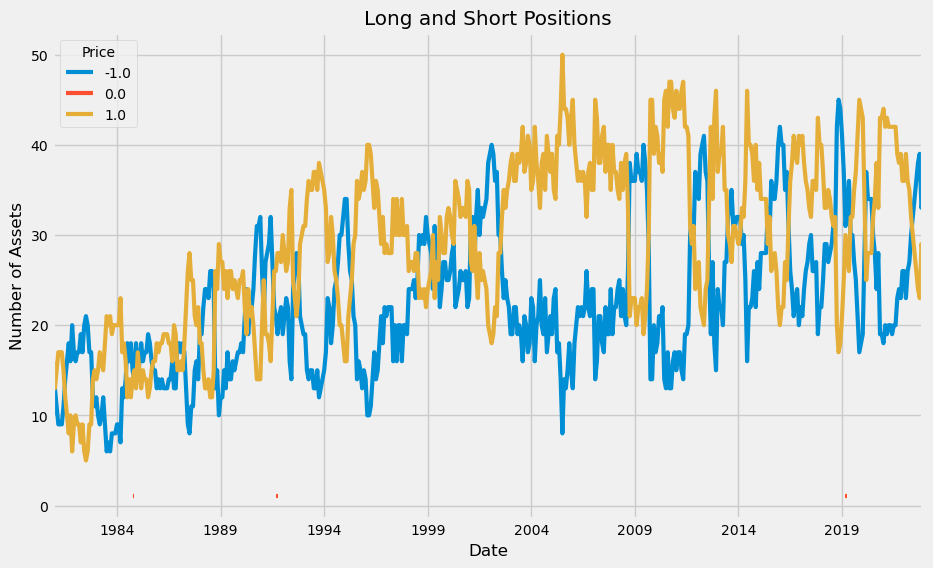

In [16]:
positions.plot(title='Long and Short Positions',
               xlabel='Date',
               ylabel='Number of Assets',
               figsize=(10,6))

Or even something more **exotic** such as an **area** plot:

<Axes: title={'center': 'Long and Short Positions'}, xlabel='Date', ylabel='Number of Assets'>

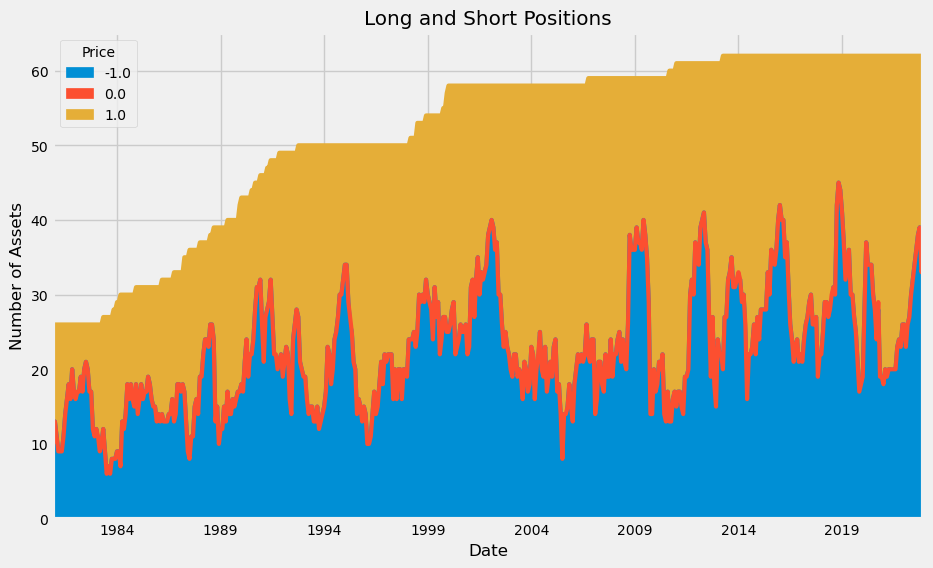

In [17]:
positions.plot(kind='area',
               title='Long and Short Positions',
               xlabel='Date',
               ylabel='Number of Assets',
               figsize=(10,6))

___
### Exercise 6B.01
This multi-asset strategy takes long and short positions on a large number of futures in four different asset classes: Equity, Bonds, Currency and commodities. it is extremely interesting to see, month by month, if we have **net long or short positions** in these macro asset classes. 

**STEP 1:** Combine the DataFrame `types` with the Series `signal`. 

In [18]:
pos_type = types.join(signal.rename('Position'))
pos_type.head()

Type  Position
Name Date                        
AEX  1984-01-31  Equity       1.0
     1984-02-29  Equity       1.0
     1984-03-30  Equity       1.0
     1984-04-30  Equity       1.0
     1984-05-31  Equity       1.0

**STEP 2:** Using the groupby operator calculate the **mean signal** for each type and each month. You will have to use **two variables** in the groupby operator.

In [19]:
exposure = pos_type.groupby(['Date', 'Type']).mean()
exposure.head()

Position
Date       Type               
1980-12-31 Commodity  0.384615
           Currency  -0.428571
           Equity     0.666667
1981-01-30 Commodity -0.076923
           Currency  -0.428571

**STEP 3:** If you have completed the previous step correctly your result should be a DataFrame indexed by `Date` and `Type`. For every date you should have multiple rows with the different types of assets (Commodity, Equity, ...). Use the **[`DataFrame.unstack()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.unstack.html)** method to move each asset into a **different column**.

In [20]:
exposure = exposure.unstack(1)
exposure.head()

Position                              
Type          Bonds Commodity  Currency    Equity
Date                                             
1980-12-31      NaN  0.384615 -0.428571  0.666667
1981-01-30      NaN -0.076923 -0.428571  0.666667
1981-02-27      NaN  0.230769 -0.142857  0.333333
1981-03-31      NaN  0.538462 -0.714286  1.000000
1981-04-30      NaN  0.230769 -0.142857  1.000000

**STEP 4:** You can now plot the net exposure to each asset class with a plot function. You should use:
- A line plot
- With an appropriate title
- With the option `subplots=True` so that each line is in a separate graph

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

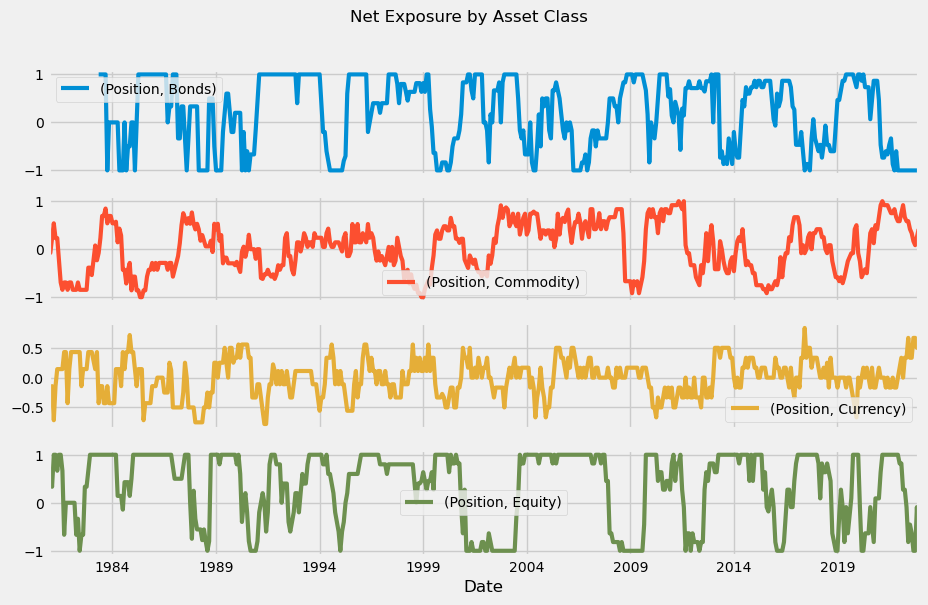

In [21]:
exposure.plot(figsize=(10,6),
              title='Net Exposure by Asset Class',
              subplots=True)

**STEP 5:** Theory question. If you have done the last part correctly you should notice that equities often have a **net exposutre** of `+1`, meaning that we have a **long position in all** the equity markets **at the same time**. The same is not true for commodities. Any idea why?

___
## 4. The Position Size
From the AQR documents we know that the dollar amount invested in each asset (long or short) is **inversely proportional** to the annualized past **volatility of the asset** to match a "target volatility" of each position of `40%`. So the investment in asset $s$ at time $t$ is:

$$X_{s,t} = \frac{40\%}{\sigma^{s}_{t}}$$

We can start by calculating the monthly returns:

In [22]:
returns =  np.log(prices / prices.groupby('Name').shift(1)).dropna()
returns.head()

Name  Date      
AEX   1983-02-28    0.058031
      1983-03-31    0.161426
      1983-04-29   -0.051783
      1983-05-31    0.000699
      1983-06-30    0.111786
Name: Price, dtype: float64

Now we need to calculate, for every observation (each asset and each month), the standard deviation of the returns in, let's say, the last twelve months. This is trivial in Pandas using the **[`DataFrame.rolling()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html)** method that allows to perform **rolling window calculations**. For example we can calculate the annualized standard deviation as:

In [23]:
dev = returns.groupby('Name').rolling(12).std()*np.sqrt(12)
dev.head(15)

Name  Name  Date      
AEX   AEX   1983-02-28         NaN
            1983-03-31         NaN
            1983-04-29         NaN
            1983-05-31         NaN
            1983-06-30         NaN
            1983-07-29         NaN
            1983-08-31         NaN
            1983-09-30         NaN
            1983-10-31         NaN
            1983-11-30         NaN
            1983-12-30         NaN
            1984-01-31    0.251736
            1984-02-29    0.294752
            1984-03-30    0.260780
            1984-04-30    0.255239
Name: Price, dtype: float64

Please notice that we have to apply the **groupby** operator because we want to perform a calculation **for each asset separately**. We also pass `12` as an argument for the `df.rolling()` method because we want to use 12 observations for the calculation. After the rolling operator we can **concatenate any function** we want to apply to the rolling window of data, in this case the standard deviation **[`Series.std()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.std.html)**. Finally we have to multiply the result by the **square root of 12** to annualize the monthly standard deviation using the NumPy function **[`np.sqrt()`](https://numpy.org/doc/stable/reference/generated/numpy.sqrt.html)**. 

A problem with this is that while it is nice to use a long sample of historical observations, we also recognize that **old information is less useful**: the volatility of the asset 12 months ago may **not represent the current** market situation.

To minimize this problem AQR uses an [Exponentially Weighted Standard Deviation](https://en.wikipedia.org/wiki/Exponential_smoothing) where more recent observations have a stronger weight in the calculation. They also indicate that they apply this calculation with a _Center of Mass of 60 days_. This indicates that **50% of the weight** of the calculation is on the most recent 60 days of observations.

While the mathematical formula in the AQR paper is quite complicated, since this is a standard financial technique, we can find a ready-made function in Pandas **[`DataFrame.ewm()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html)** to achieve the same result. 

With `halflife=3` we can achieve that 50% of the weight is on the first three observations ($t_{0}, t_{-1}, t_{-2}$). Since we are using monthly observations this gives us more or less 60 days. 

**Attention:** `df.ewm()` has a center of mass prarameter but is defined in a slightly different way.

In [24]:
dev = returns.groupby('Name').ewm(min_periods=12, halflife=3).std()*np.sqrt(12)
dev.head(15)

Name  Name  Date      
AEX   AEX   1983-02-28         NaN
            1983-03-31         NaN
            1983-04-29         NaN
            1983-05-31         NaN
            1983-06-30         NaN
            1983-07-29         NaN
            1983-08-31         NaN
            1983-09-30         NaN
            1983-10-31         NaN
            1983-11-30         NaN
            1983-12-30         NaN
            1984-01-31    0.259664
            1984-02-29    0.345383
            1984-03-30    0.307694
            1984-04-30    0.283553
Name: Price, dtype: float64

Before we proceed you will notice that applying the rolling operator with groupby has generated a **funny artifact**, now our MultiIndex has three levels, with the **name appearing twice**... We need to get rid of one:

In [25]:
dev = dev.reset_index(0,drop=True).dropna()
dev.head()

Name  Date      
AEX   1984-01-31    0.259664
      1984-02-29    0.345383
      1984-03-30    0.307694
      1984-04-30    0.283553
      1984-05-31    0.282826
Name: Price, dtype: float64

And the **size of the position** is simply:

In [26]:
pos_size = 0.4/dev
pos_size.head()

Name  Date      
AEX   1984-01-31    1.540450
      1984-02-29    1.158133
      1984-03-30    1.299994
      1984-04-30    1.410672
      1984-05-31    1.414295
Name: Price, dtype: float64

___
## 5. The Investment Position
Now that we have the long/short signal and the position size, we can simply calculate the **position (or investment)** by multiplying the two. Since they have the same MultiIndex pandas will take care to **match the rows properly**.

In [27]:
position = signal * pos_size
position.head()

Name  Date      
AEX   1984-01-31    1.540450
      1984-02-29    1.158133
      1984-03-30    1.299994
      1984-04-30    1.410672
      1984-05-31    1.414295
Name: Price, dtype: float64

We need to remember that our signal is equal to `+1` if we want to buy the asset and `-1` if we want to sell, so our position also will be **positive or negative**. 

___
## 6. The Performance
We are finally ready to see how the strategy performs. First of all we can calculate the **"next-month return"**, that is the return over our holding period, and **join it together** with the position in the same DataFrame. Please remember that **[`DataFrame.join()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html)** does not work with series, so we need to transform the first Series into a DataFrame with **[`Series.to_frame()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.to_frame.html)**. 

In [28]:
holding_returns = np.log(prices.groupby('Name').shift(-1) / prices).rename('return')

portfolio = position.rename('Position').to_frame().join(holding_returns)
portfolio.head()

Position    return
Name Date                          
AEX  1984-01-31  1.540450 -0.106824
     1984-02-29  1.158133  0.001942
     1984-03-30  1.299994 -0.030998
     1984-04-30  1.410672 -0.076204
     1984-05-31  1.414295  0.023196

The **profit or loss** of each position is simply the product of the position times the next-month return.

In [29]:
portfolio['Port_ret'] = portfolio['Position']*portfolio['return']
portfolio.head()

Position    return  Port_ret
Name Date                                    
AEX  1984-01-31  1.540450 -0.106824 -0.164557
     1984-02-29  1.158133  0.001942  0.002249
     1984-03-30  1.299994 -0.030998 -0.040297
     1984-04-30  1.410672 -0.076204 -0.107498
     1984-05-31  1.414295  0.023196  0.032805

### 6.1 The Benchmark
It is always diffcult to assess the quality of a portfolio strategy in isolation. We always look for a **"neutral portfolio"** to be used as **comparison**. For example if your strategy is designed to select the "best stocks" on the US market, you may want to use the S&P 500 as your "neutral portfolio" or **Benchmark**. The idea is that you could save the cost of building your strategy and simply invest in every major US company...

Here the most intuitive "neutral portfolio", is one where we **invest $1 in every asset class** without choosing whether we should go long or short and without estimating the optimal position size. We can easily:
- Build te Benchmark
- Calculate its return
- Calculate the "Active" return of the portfolio as the return above the Benchmark (above the "dumb" strategy). 

In [30]:
portfolio['Benchmark'] = 1
portfolio['Bench_ret'] = portfolio['Benchmark']*portfolio['return']
portfolio['Active_ret'] = portfolio['Port_ret'] - portfolio['Bench_ret']
portfolio.head()

Position    return  Port_ret  Benchmark  Bench_ret  \
Name Date                                                             
AEX  1984-01-31  1.540450 -0.106824 -0.164557          1  -0.106824   
     1984-02-29  1.158133  0.001942  0.002249          1   0.001942   
     1984-03-30  1.299994 -0.030998 -0.040297          1  -0.030998   
     1984-04-30  1.410672 -0.076204 -0.107498          1  -0.076204   
     1984-05-31  1.414295  0.023196  0.032805          1   0.023196   

                 Active_ret  
Name Date                    
AEX  1984-01-31   -0.057733  
     1984-02-29    0.000307  
     1984-03-30   -0.009299  
     1984-04-30   -0.031295  
     1984-05-31    0.009610

Of course we are not interested in the profit/loss of each **individual asset**, but the **total performance** of the portfolio. We can simply calculate this by **taking the average** of all the positions within each month. 

Please notice that we take the average, and not the sum, because we assume to invest a **fixed amount of money** ($1) at the beginning of each month. 

In [31]:
performance = portfolio[['Port_ret', 'Bench_ret', 'Active_ret']].groupby('Date').mean()
performance.head()

,Port_ret,Bench_ret,Active_ret
Date,,,
1980-12-31,-0.003680,-0.047446,0.043767
1981-01-30,-0.017431,-0.001890,-0.015542
1981-02-27,0.000450,0.015863,-0.015413
1981-03-31,0.016648,-0.013067,0.029715
1981-04-30,0.000518,-0.009167,0.009686


### 6.2 The Diagnostics
Now that we have the monthly performance of our portfolio we can calculate the **usual diagnostics**:
- Mean Return
- Standard Deviation
- Sharpe Ratio

In [32]:
mean_ret =performance.mean()*12
mean_ret

Port_ret      0.082982
Bench_ret     0.017278
Active_ret    0.065705
dtype: float64

In [33]:
st_dev = performance.std()*np.sqrt(12)
st_dev

Port_ret      0.147034
Bench_ret     0.072487
Active_ret    0.160787
dtype: float64

In [34]:
sharpe = mean_ret/st_dev
sharpe

Port_ret      0.564374
Bench_ret     0.238358
Active_ret    0.408644
dtype: float64

We can easily see that the **performance is similar** to what can be found in the AQR articles (gross of transaction costs that we have not considered here).

### 6.3 Plotting Performance
We can also plot the performance of the portfolio. To do this, we need to convert monthly returns into a series of portfolio prices. Since we are using logarithmic returns this is trivial. We know that if an asset has, in three periods, returns equal to $r_{1}$, $r_{2}$ and $r_{3}$, than the return from time 0 to time 3 is simply the sum
$$r_{0, 3} = \sum_{t=1}^{3}r_{t}$$

And we also know that the dollar value at the end of time 3 of a $1 investment in time 0 is

$$W_{3} = \$1\times e^{r_{0, 3}}$$

We can simply apply the Numpy exponential function [**`numpy.exp()`**](https://numpy.org/doc/stable/reference/generated/numpy.exp.html) to the cumulative returns calculated using the [**`DataFrame.cumsum()`**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.cumsum.html) method. 

In [35]:
port_values = performance.cumsum().apply(np.exp)
port_values.head()

,Port_ret,Bench_ret,Active_ret
Date,,,
1980-12-31,0.996327,0.953662,1.044739
1981-01-30,0.979110,0.951861,1.028627
1981-02-27,0.979551,0.967081,1.012894
1981-03-31,0.995994,0.954527,1.043443
1981-04-30,0.996511,0.945816,1.053599


<Axes: xlabel='Date'>

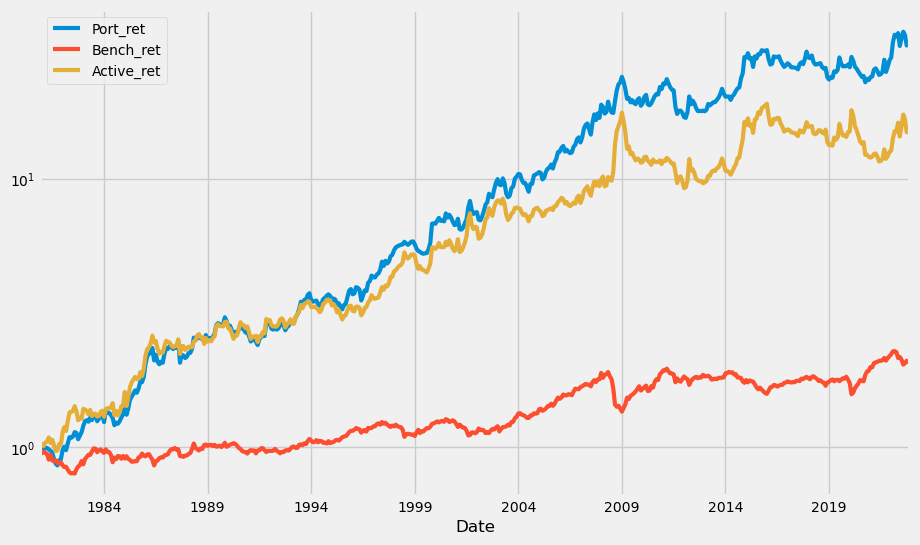

In [36]:
port_values.plot(figsize=(10, 6),
                 logy=True)

### 6.4 Yearly Performance
From the previous graph, we notice that the performance of the strategy has **slowed down after the GFC**. It may be interesting to look at the strategy year by year. To do this, we want to first of all **extract the year** of each obsrvation from the index of the DataFrame.

In [37]:
performance['Year'] = performance.index.year
performance.head()

,Port_ret,Bench_ret,Active_ret,Year
Date,,,,
1980-12-31,-0.003680,-0.047446,0.043767,1980
1981-01-30,-0.017431,-0.001890,-0.015542,1981
1981-02-27,0.000450,0.015863,-0.015413,1981
1981-03-31,0.016648,-0.013067,0.029715,1981
1981-04-30,0.000518,-0.009167,0.009686,1981


We can calculate the **annual performance** by simply summing the monthly returns within each calendar year: 

In [38]:
annual_perf = performance.groupby('Year').sum()
annual_perf.head()

,Port_ret,Bench_ret,Active_ret
Year,,,
1980,-0.003680,-0.047446,0.043767
1981,-0.097118,-0.078718,-0.018400
1982,0.231830,0.009664,0.222166
1983,0.150140,0.082173,0.067967
1984,0.003764,-0.038119,0.041883


We can then do a **bar plot** with the **total return** within each calendar year. This simply the sum of the monthly returns. 

<Axes: xlabel='Year'>

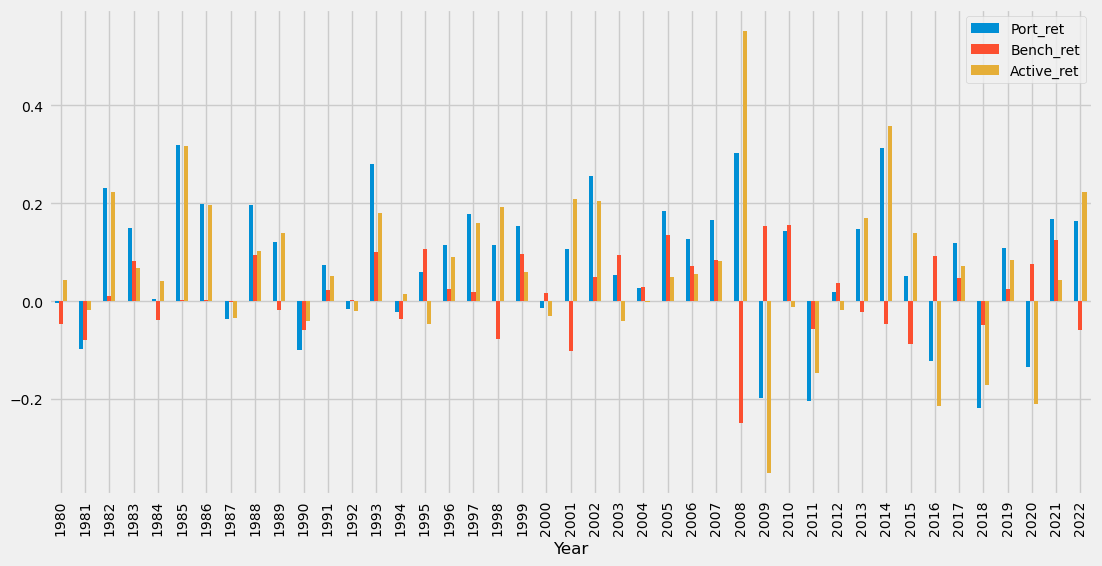

In [39]:
annual_perf.plot(kind='bar',
                 figsize=(12,6))

This graph produces what is likely the **most interesting result**. This strategy has outperformed the benchmark almost every year **until the GFC**. After that moment we have a 50% hit rate...we are almost **as likely to underperform** as to overperform a dumb strategy that simply goes long in every asset.

It is difficult to say what may have changed. After the GFC **interest rates** have been extremely low all over the developed world, and this could have changed the structure of asset returns. 

Another interesting hypothesis is that the Moskowitz et al. (2012) paper that showed the profitability of this strategy started **circulating as a working paper** around 2008-2009, so maybe once market participants **started using** this investment approach they **made the market more efficient** killing the profitability of the strategy itself...


___
### Exercise 6B.02
Your boss is very intrigued by this issue. Specifically if the performance of this strategy is **tied to high interest rates**, than this would mean that **now would be a good time** to implement this model. Let's test this hypothesis:

**STEP 1:** The file `10Y_Rate.csv` contains monthly interest rates (Yield to maturity) of a **10 Year US government bond**. Load the content of this file into a DataFrame called `rates`. Index the DataFrame by Date. Also, add to this DataFrame a column containing the calendar year of the date (similarly to what we did in point 6.4 in this notebook. 


In [40]:
rates = pd.read_csv('10Y_Rate.csv', parse_dates=['Date']).set_index('Date')
rates['Year'] = rates.index.year
rates.head()

,10Y-Rate,Year
Date,,
1982-01-01,7.623742,1982
1982-01-02,7.656648,1982
1982-01-03,7.128993,1982
1982-01-04,7.408347,1982
1982-01-05,7.320041,1982


**STEP 2:** Using the `DataFrame.groupby()` operator create a new DataFrame or Series called `avg_rate` with the average interest rate in each calendar year. 

In [41]:
avg_rate = rates.groupby('Year')['10Y-Rate'].mean()
avg_rate.head()

Year
1982    6.934689
1983    5.888257
1984    6.637399
1985    5.660393
1986    4.048303
Name: 10Y-Rate, dtype: float64

**STEP 3:** Create a new DataFrame called `correlation_test` by joining `avg_rate` with the DataFrame `annual_perf` previously created in the notebook.

In [42]:
corr_test = annual_perf.join(avg_rate)
corr_test.head()

,Port_ret,Bench_ret,Active_ret,10Y-Rate
Year,,,,
1980,-0.003680,-0.047446,0.043767,NaN
1981,-0.097118,-0.078718,-0.018400,NaN
1982,0.231830,0.009664,0.222166,6.934689
1983,0.150140,0.082173,0.067967,5.888257
1984,0.003764,-0.038119,0.041883,6.637399


**STEP 4:** Using the method **[`DataFrame.corr()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html)** calculate the correlation between the columns of the DataFrame `correlation_test`.

In [43]:
corr_test.corr()

,Port_ret,Bench_ret,Active_ret,10Y-Rate
Port_ret,1.000000,0.015222,0.863581,0.213275
Bench_ret,0.015222,1.000000,-0.491006,-0.063192
Active_ret,0.863581,-0.491006,1.000000,0.212918
10Y-Rate,0.213275,-0.063192,0.212918,1.000000


**STEP 5:** Write a brief commentary for your boss answering the question: _does this strategy works better in a high-interest environment?_

**Answer:** The return of the strategy shows a strong and positive correlation with the average level of the interest rate. The same is NOT true for the benchmark. This indicates that indeed the strategy seems to perform better in high-interest environments. 